In [ ]:
!pip install vbeam

# Beamforming with a `TransmittedWavefront` that returns multiple distance samples
This notebook showcases an "advanced" implementation of a `TransmittedWavefront` model that returns multiple transmit distance samples.

The wavefront model that we will implement in this notebook is called `SmoothedWavefront`. It takes another wavefront model and an array of distance offsets as arguments, and when we calculate the distance, the offsets are added to the result. If the offsets are small enough then this is the same as smoothing in the time-axis.

This is only to showcase `vbeam`'s flexibility and support for different types of wavefront models. There are better ways to smooth along the time-axis than using a custom `TransmittedWavefront` class.

## Loading example data
Let's start by loading a dataset. We use the `PICMUS_carotid_cross.uff`, downloaded from www.ustb.no, which is a plane wave imaging setup. We rescale the scan grid to `(100, 100)` in order to speed up the beamforming. We use the "default" beamformer created by `vbeam` by calling `get_beamformer(setup)`.

/home/magnusk/miniconda3/envs/vbeam/lib/python3.9/site-packages/pyuff_ustb/readers/lazy_arrays/base.py:103: RuntimeWarning: invalid value encountered in multiply
  return self[...] * other
/home/magnusk/vbeam/vbeam/data_importers/setup.py:45: UserWarning: point_position will be overwritten by the scan.
  warnings.warn("point_position will be overwritten by the scan.")


(-0.5, 99.5, 99.5, -0.5)

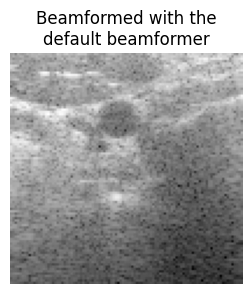

In [1]:
import jax
import matplotlib.pyplot as plt
import pyuff_ustb as pyuff

from vbeam.beamformers import get_das_beamformer
from vbeam.data_importers import import_pyuff
from vbeam.util.download import cached_download

# Download (or read from cache) and load the UFF file
data_url = "http://www.ustb.no/datasets/PICMUS_carotid_cross.uff"
uff = pyuff.Uff(cached_download(data_url))
# Import the channel data and scan configuration from the UFF file
setup = import_pyuff(uff.read("/channel_data"), uff.read("/scan"), frames=0)
# Resize the grid to make the beamforming faster (though the image will be undersampled)
setup.scan = setup.scan.resize(x=100, z=100)

# Create a "default" beamformer. Wrap it in jax.jit to make it run fast with JAX :)
beamformer = jax.jit(get_das_beamformer(setup))
# Beamform the imported data
result = beamformer(**setup.data)

# Plot the result
plt.figure(figsize=(3, 3))
plt.title("Beamformed with the\ndefault beamformer")
plt.imshow(result.T, aspect="auto", cmap="gray"); plt.axis("off")


## Defining the `SmoothedWavefront` class
For calculating the transmit distance, the `SmoothedWavefront` will return the distance from another given wavefront model with some offsets added to it. For example, if the distance is `0.1` and the offsets are `[-1, 0, 1]`, then the returned transmit distances will be `[0.1-1, 0.1+0, 0.1+1]` = `[-0.9, 0.1, 1.1]`.

The result of using `SmoothedWavefront` is a more smooth image. This can be seen when comparing the default beamformer image with the one that uses `SmoothedWavefront`.

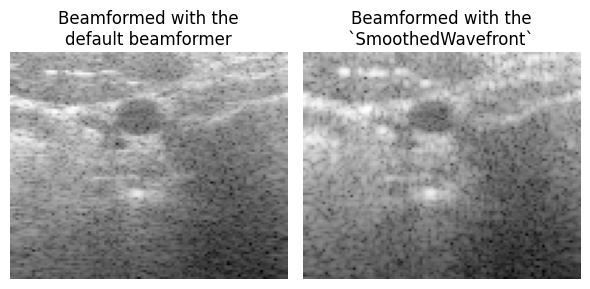

In [2]:
import jax.numpy as jnp

from vbeam.apodization import Hamming
from vbeam.core import (
    ElementGeometry,
    MultipleTransmitDistances,
    TransmittedWavefront,
    WaveData,
)
from vbeam.fastmath.traceable import traceable_dataclass


@traceable_dataclass(("base_wavefront", "offsets"))
class SmoothedWavefront(TransmittedWavefront):
    # The wavefront that we are adding the offsets to
    base_wavefront: TransmittedWavefront
    # The offsets: an array of shape (N,), where N are the number of distance offsets
    offsets: jnp.ndarray

    def __call__(
        self,
        sender: ElementGeometry,
        point_position: jnp.ndarray,
        wave_data: WaveData,
    ) -> MultipleTransmitDistances:
        # Calculate the distance to the point
        distance = self.base_wavefront(sender, point_position, wave_data)

        # Add the offsets to the distance
        offset_distances = self.offsets + distance

        # Let's weight the offset samples using Hamming (arbitrarily chosen)
        weights = Hamming()(jnp.linspace(-0.5, 0.5, self.offsets.shape[0]))

        # Return a weighted sum of the samples
        aggregate_samples = lambda samples: jnp.sum(samples * weights)
        return MultipleTransmitDistances(offset_distances, aggregate_samples)


# We create a SmoothedWavefront with 5 offsets in the range [-2 mm, 2 mm]
smoothed_wavefront = SmoothedWavefront(
    setup.transmitted_wavefront, jnp.linspace(-2e-3, 2e-3, 5)
)
smoothed_result = beamformer(
    **{**setup.data, "transmitted_wavefront": smoothed_wavefront}
)

fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
ax[0].set_title("Beamformed with the\ndefault beamformer")
ax[0].imshow(result.T, aspect="auto", cmap="gray")
ax[0].axis("off")
ax[1].set_title("Beamformed with the\n`SmoothedWavefront`")
ax[1].imshow(smoothed_result.T, aspect="auto", cmap="gray")
ax[1].axis("off")
fig.tight_layout()